### **M5 forecasting accuracy**

The dataset shared is the sales data for Walmart stores in three states - California, Texas and Wisconsin. From the EDA we have seen that the sales of most of the items is a time series, i.e, depends on the day, event on that day, selling price or offers etc. The sales data shared has details for 6 years(2011 to 2016). Here we are trying to forecast the sales for the next 28 days.  

For the PoC purpose, since we are predicting daily sales, it is better to consider only best selling lines. The sales of those products should also show seasonal or time dependent pattern. Hence, based on sold units and auto-correlation plot, Seven best selling lines of Texas stores are picked from the dataset. The sales details and the calendar details are used as input. 

The below solution is designed using Tensorflow Keras framework and ConvLSTM. ConvLSTM is slightly different from normal LSTMs, here the matrix multiplication operations present in each gates, is replaced by Convolutions.


In [62]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, ConvLSTM2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

Read the required datasets in csv format into dataframes

In [2]:
#Read the csv file
sell_prices_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/sell_prices.csv'
sales_train_evaluation_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/sales_train_evaluation.csv'
sales_train_validation_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/sales_train_validation.csv'
calendar_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/calendar.csv'
calendar_edited_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/calendar_before_after.csv'
sales_train_evaluation_gr50_TX_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/sales_train_evaluation_gr50_TX.csv'
calendar = pd.read_csv(calendar_path)
sales_train_evaluation_df = pd.read_csv(sales_train_evaluation_gr50_TX_path)
#calendar_df = pd.read_csv(calendar_edited_path)
sales_dates = pd.to_datetime(calendar['date'])[:1941]

Pre-processed the input dataset to the below format, combination of (Product, events, weekday). This was done 

In [4]:
sales_train_evaluation_df.columns

Index(['id', 'FOODS_3_090_TX_1_evaluation', 'event_name_1', 'wday',
       'FOODS_3_318_TX_1_evaluation', 'event_name_1.1', 'wday.1',
       'FOODS_3_586_TX_1_evaluation', 'event_name_1.2', 'wday.2',
       'FOODS_3_090_TX_2_evaluation', 'event_name_1.3', 'wday.3',
       'FOODS_3_252_TX_2_evaluation', 'event_name_1.4', 'wday.4',
       'FOODS_3_318_TX_2_evaluation', 'event_name_1.5', 'wday.5',
       'FOODS_3_555_TX_2_evaluation', 'event_name_1.6', 'wday.6',
       'FOODS_3_586_TX_2_evaluation', 'event_name_1.7', 'wday.7',
       'FOODS_3_587_TX_2_evaluation', 'event_name_1.8', 'wday.8',
       'FOODS_2_360_TX_3_evaluation', 'event_name_1.9', 'wday.9',
       'FOODS_3_090_TX_3_evaluation', 'event_name_1.10', 'wday.10',
       'FOODS_3_252_TX_3_evaluation', 'event_name_1.11', 'wday.11',
       'FOODS_3_318_TX_3_evaluation', 'event_name_1.12', 'wday.12',
       'FOODS_3_555_TX_3_evaluation', 'event_name_1.13', 'wday.13',
       'FOODS_3_586_TX_3_evaluation', 'event_name_1.14', 'wday.14'

Picking only those lines having good auto-correlation.

In [5]:
sales_subset = sales_train_evaluation_df.set_index('id')
sales_cols = sales_subset.columns
col_index_to_pick = [6,7,8,12,13,14,18,19,20,21,22,23,33,34,35,39,40,41,42,43,44]
sales_cols_picked = []
for i in range(0,len(sales_cols)):
    if i in col_index_to_pick:
        sales_cols_picked.append(sales_cols[i])
        
sales_subset_2_items = sales_subset[sales_cols_picked]

In [6]:
training_data = sales_subset_2_items

cols = training_data.columns
print(cols)

Index(['FOODS_3_586_TX_1_evaluation', 'event_name_1.2', 'wday.2',
       'FOODS_3_252_TX_2_evaluation', 'event_name_1.4', 'wday.4',
       'FOODS_3_555_TX_2_evaluation', 'event_name_1.6', 'wday.6',
       'FOODS_3_586_TX_2_evaluation', 'event_name_1.7', 'wday.7',
       'FOODS_3_252_TX_3_evaluation', 'event_name_1.11', 'wday.11',
       'FOODS_3_555_TX_3_evaluation', 'event_name_1.13', 'wday.13',
       'FOODS_3_586_TX_3_evaluation', 'event_name_1.14', 'wday.14'],
      dtype='object')


The Event information needs to be encoded, inorder to do any computaion. Categorical encoding method is used here. Each event is considered a category. Before event and After events are also marked as categories.

In [8]:
cols_for_ordinal = cols[1::3]

enc = OrdinalEncoder()

training_data_3 = training_data
training_data_3[cols_for_ordinal] = enc.fit_transform(training_data[cols_for_ordinal])

Index(['FOODS_3_586_TX_1_evaluation', 'event_name_1.2', 'wday.2',
       'FOODS_3_252_TX_2_evaluation', 'event_name_1.4', 'wday.4',
       'FOODS_3_555_TX_2_evaluation', 'event_name_1.6', 'wday.6',
       'FOODS_3_586_TX_2_evaluation', 'event_name_1.7', 'wday.7',
       'FOODS_3_252_TX_3_evaluation', 'event_name_1.11', 'wday.11',
       'FOODS_3_555_TX_3_evaluation', 'event_name_1.13', 'wday.13',
       'FOODS_3_586_TX_3_evaluation', 'event_name_1.14', 'wday.14'],
      dtype='object')


/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


LSTM uses sigmoid and tanh functions that are sensitive to magnitude, so values need to be normalized.
StandardScaler from scikit-learn library is used to normalize the dataset.

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(training_data_3)
training_data_scaled = scaler.transform(training_data_3)

Reformat the input to have previous values based on the timesteps configured.

In [55]:
no_of_lines = 21
timesteps = 14
startDay = 0      #start from 1st day itself. 

X_train = []
Y_train = []
for i in range(timesteps, 1941 - startDay):
    X_train.append(training_data_scaled[i-timesteps:i])
    Y_train.append(training_data_scaled[i][::3])
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)

(1927, 14, 21)
(1927, 7)


Callbacks are configured to stop the model training when the accuracy is not improving any further or choose the best trained model weights. Here we have configured "EarlyStopping" to stop training when the validation loss is not decreasing any further.

In [52]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min',
    restore_best_weights = True
)

The input for ConvLSTM has to be in 5D format. Reformatting the training data accordingly.
The training data is split into three sets - training, validation and test sets.

In [53]:
print(X_train.shape)
convX_traini = X_train.reshape((X_train.shape[0],1,1,X_train.shape[1],-1))

epoch_no = 100
batch_size_no = 300
train_len = 1500
val_len = 385
test_len = 28

convX_train = convX_traini[:train_len]
convX_val = convX_traini[train_len:train_len+val_len]
convX_test = convX_traini[train_len+val_len:]
convY_train = Y_train[0:train_len]
convY_val = Y_train[train_len:train_len+val_len]
convY_test = Y_train[train_len+val_len:]

(1927, 14, 21)


Model configuration having ConvLSTM, Dropout and Dense layers. 

While using StandardScaler, the sales values are converted into small scale values, some of them are negative as well. Hence, tanh activation seems to be a better choice than relu or sigmoid.

In [80]:
model = Sequential()
model.add(ConvLSTM2D(filters=32, kernel_size=(1,1), activation='tanh', input_shape=(1, 1, timesteps, X_train[0].shape[1])))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(16))
model.add(Dense(no_of_lines/3))
model.compile(optimizer='RMSprop', loss='mean_squared_error')
model.summary()

history = model.fit(convX_train, 
                    convY_train, 
                    batch_size=batch_size_no, 
                    validation_data=(convX_val, convY_val),
                    verbose=2, 
                    epochs=epoch_no,
                    callbacks=[custom_early_stopping]
                    )


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_43 (ConvLSTM2D) (None, 1, 14, 32)         6912      
_________________________________________________________________
flatten_43 (Flatten)         (None, 448)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 448)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 16)                7184      
_________________________________________________________________
dense_87 (Dense)             (None, 7)                 119       
Total params: 14,215
Trainable params: 14,215
Non-trainable params: 0
_________________________________________________________________
Train on 1500 samples, validate on 385 samples
Epoch 1/100
1500/1500 - 3s - loss: 0.9415 - val_loss: 0.6317
Epoch 2

Plot of training loss and validation loss

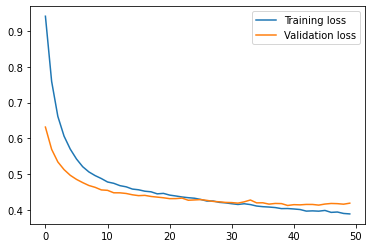

In [81]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [82]:
"""
#Y predicted test set
"""
predict_Y = model.predict(convX_test)
print(predict_Y.shape)

zeros = np.zeros((predict_Y.shape[0],14)) #2 is a number of rows in your array.   
prediction_copies = np.hstack((predict_Y, zeros))

y_pred_future = scaler.inverse_transform(prediction_copies)[:,:no_of_lines]

y_pred_future_r = np.around(y_pred_future)

"""
Y predict on training data
"""
predict_Y_t = model.predict(convX_train)

zeros = np.zeros((predict_Y_t.shape[0],14)) #2 is a number of rows in your array.   
prediction_copies = np.hstack((predict_Y_t, zeros))

y_pred_train = scaler.inverse_transform(prediction_copies)[:,:no_of_lines]

y_pred_train_r = np.around(y_pred_train)

"""
#Y actuals
"""

Y_train_plot = Y_train
zeros = np.zeros((Y_train_plot.shape[0],14)) #2 is a number of rows in your array.   
Y_train_copies = np.hstack((Y_train_plot, zeros))

Y_train_plot_r = np.around(scaler.inverse_transform(Y_train_copies)[:,:no_of_lines])
    

Y_actual_future = Y_train_plot_r[train_len+val_len:]
Y_actual_train = Y_train_plot_r[:train_len]

print(y_pred_future_r.shape)
print(Y_train_plot_r.shape)

(42, 7)
(42, 21)
(1927, 21)


Plot of Actual sales and Future prediction for 28 days, for all the 7 items considered.

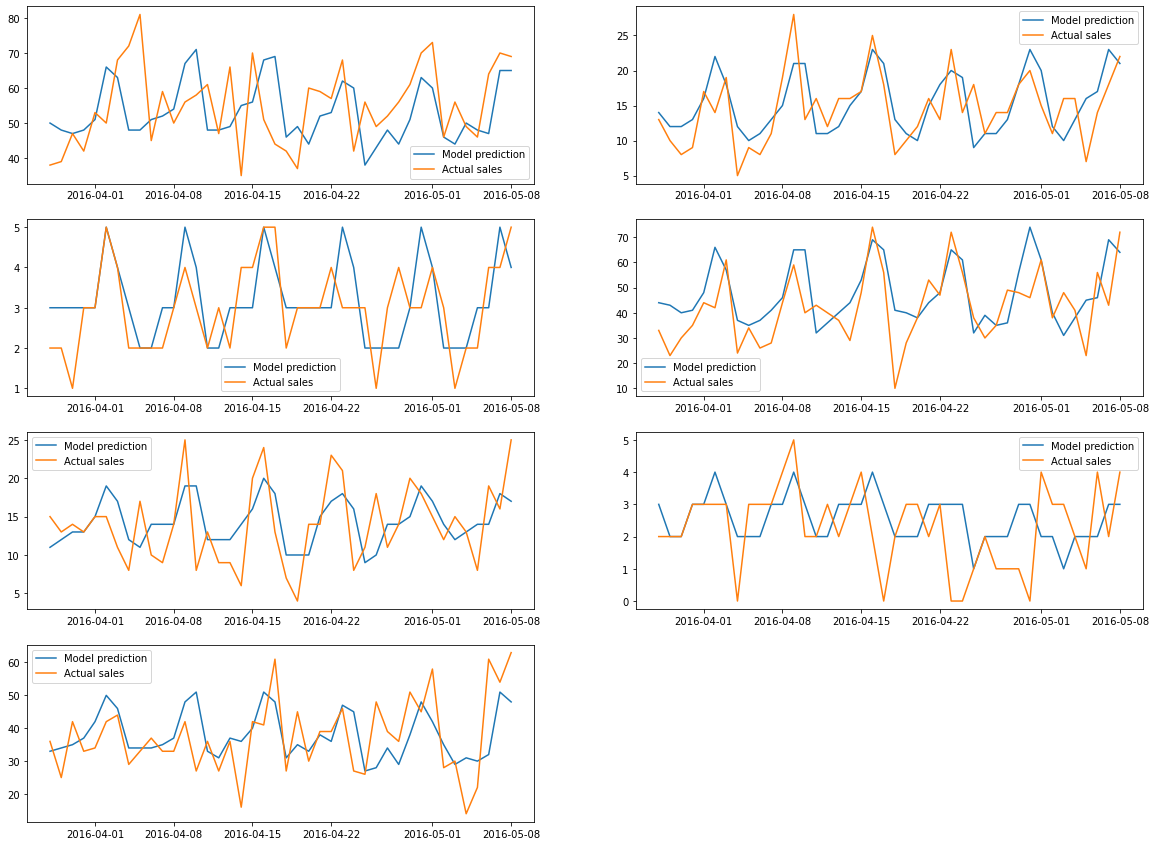

In [84]:
"""
Item wise future sales prediction 
"""

plt.figure(figsize=(20,15))
item_no = 1
a = 4
b = 2
c = 1
for i in range(0, 7):
    plt.subplot(a,b,c+i)
    plt.plot(sales_dates[train_len+val_len:train_len+val_len+42], y_pred_future_r[:,i], label='Model prediction')
    plt.plot(sales_dates[train_len+val_len:train_len+val_len+42],Y_train_plot_r[train_len+val_len:train_len+val_len+42,i], label='Actual sales')
    plt.legend()

### Future enhancements:

The Actual vs predicted sales shows most of the spikes are identified. Yet there is scope for improvement.

1. The day before and the day after any event, be it religious, sports or national events are considered same. The day of national events, sales may be low. But the day of sports events may have good sales. Before and After days to be marked based on Event type. This should help the model understand the event based sales better. 
2. Here we used only one channel for convLSTM layer. We can try to have sales, calendar events, selling price as separate channels and then pass it on to convLSTM.
3. Tried multiple cost functions - Adam, Adadelta, RMSprop. So far RMSprop gave best results. Need to try other cost functions and custom loss functions.
4. Other types of LSTM - Bayesian LSTM or other architectures where we can have a CNN layer first, the result is then fed to LSTM layer can also be tried.
